##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/spice"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/spice.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/spice.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/spice.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/spice/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Pitch Detection with SPICE

This colab will show you how to use the SPICE model downloaded from TensorFlow Hub.

In [2]:
# All the imports to deal with sound data
!pip install pydub librosa music21

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

tensorflow: 2.15.0


# The audio input file
Now the hardest part: Record your singing! :)

We provide four methods to obtain an audio file:

1.   Record audio directly in colab
2.   Upload from your computer
3.   Use a file saved on Google Drive
4.   Download the file from the web

Choose one of the four methods below.

In [4]:
#@title [Run this] Definition of the JS code to record audio straight from the browser

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

In [5]:
#@title Select how to input your audio  { run: "auto" }
INPUT_SOURCE = 'https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav' #@param ["https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav", "RECORD", "UPLOAD", "./drive/My Drive/YOUR_MUSIC_FILE.wav"] {allow-input: true}

uploaded_file_name = 'creep_by_radiohead.wav'


# print('You selected', INPUT_SOURCE)

# if INPUT_SOURCE == 'RECORD':
#   uploaded_file_name = record(5)
# elif INPUT_SOURCE == 'UPLOAD':
#   try:
#     from google.colab import files
#   except ImportError:
#     print("ImportError: files from google.colab seems to not be available")
#   else:
#     uploaded = files.upload()
#     for fn in uploaded.keys():
#       print('User uploaded file "{name}" with length {length} bytes'.format(
#           name=fn, length=len(uploaded[fn])))
#     uploaded_file_name = next(iter(uploaded))
#     print('Uploaded file: ' + uploaded_file_name)
# elif INPUT_SOURCE.startswith('./drive/'):
#   try:
#     from google.colab import drive
#   except ImportError:
#     print("ImportError: files from google.colab seems to not be available")
#   else:
#     drive.mount('/content/drive')
#     # don't forget to change the name of the file you
#     # will you here!
#     gdrive_audio_file = 'YOUR_MUSIC_FILE.wav'
#     uploaded_file_name = INPUT_SOURCE
# elif INPUT_SOURCE.startswith('http'):
#   !wget --no-check-certificate 'https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav' -O c-scale.wav
#   uploaded_file_name = 'c-scale.wav'
# else:
#   print('Unrecognized input format!')
#   print('Please select "RECORD", "UPLOAD", or specify a file hosted on Google Drive or a file from the web to download file to download')

# Preparing the audio data

Now we have the audio, let's convert it to the expected format and then listen to it!

The SPICE model needs as input an audio file at a sampling rate of 16kHz and with only one channel (mono). 

To help you with this part, we created a function (`convert_audio_for_model`) to convert any wav file you have to the model's expected format:

In [6]:
# Function that converts the user-created audio to the format that the model 
# expects: bitrate 16kHz and only one channel (mono).

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [7]:
# Converting to the expected format for the model
# in all the input 4 input method before, the uploaded file name is at
# the variable uploaded_file_name
converted_audio_file = convert_audio_for_model(uploaded_file_name)

In [8]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 9.45s
Size of the input: 151190


First thing, let's take a look at the waveform of our singing.

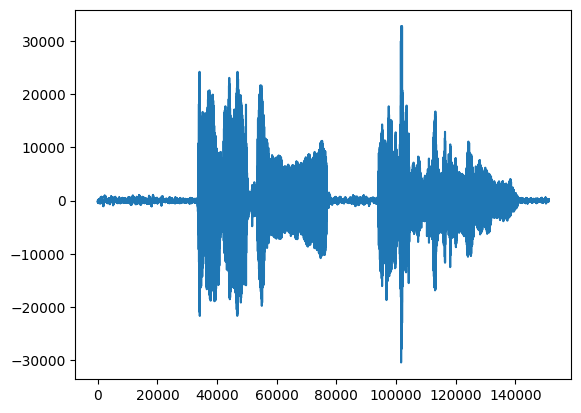

In [9]:
# We can visualize the audio as a waveform.
_ = plt.plot(audio_samples)

A more informative visualization is the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), which shows frequencies present over time.

Here, we use a logarithmic frequency scale, to make the singing more clearly visible.


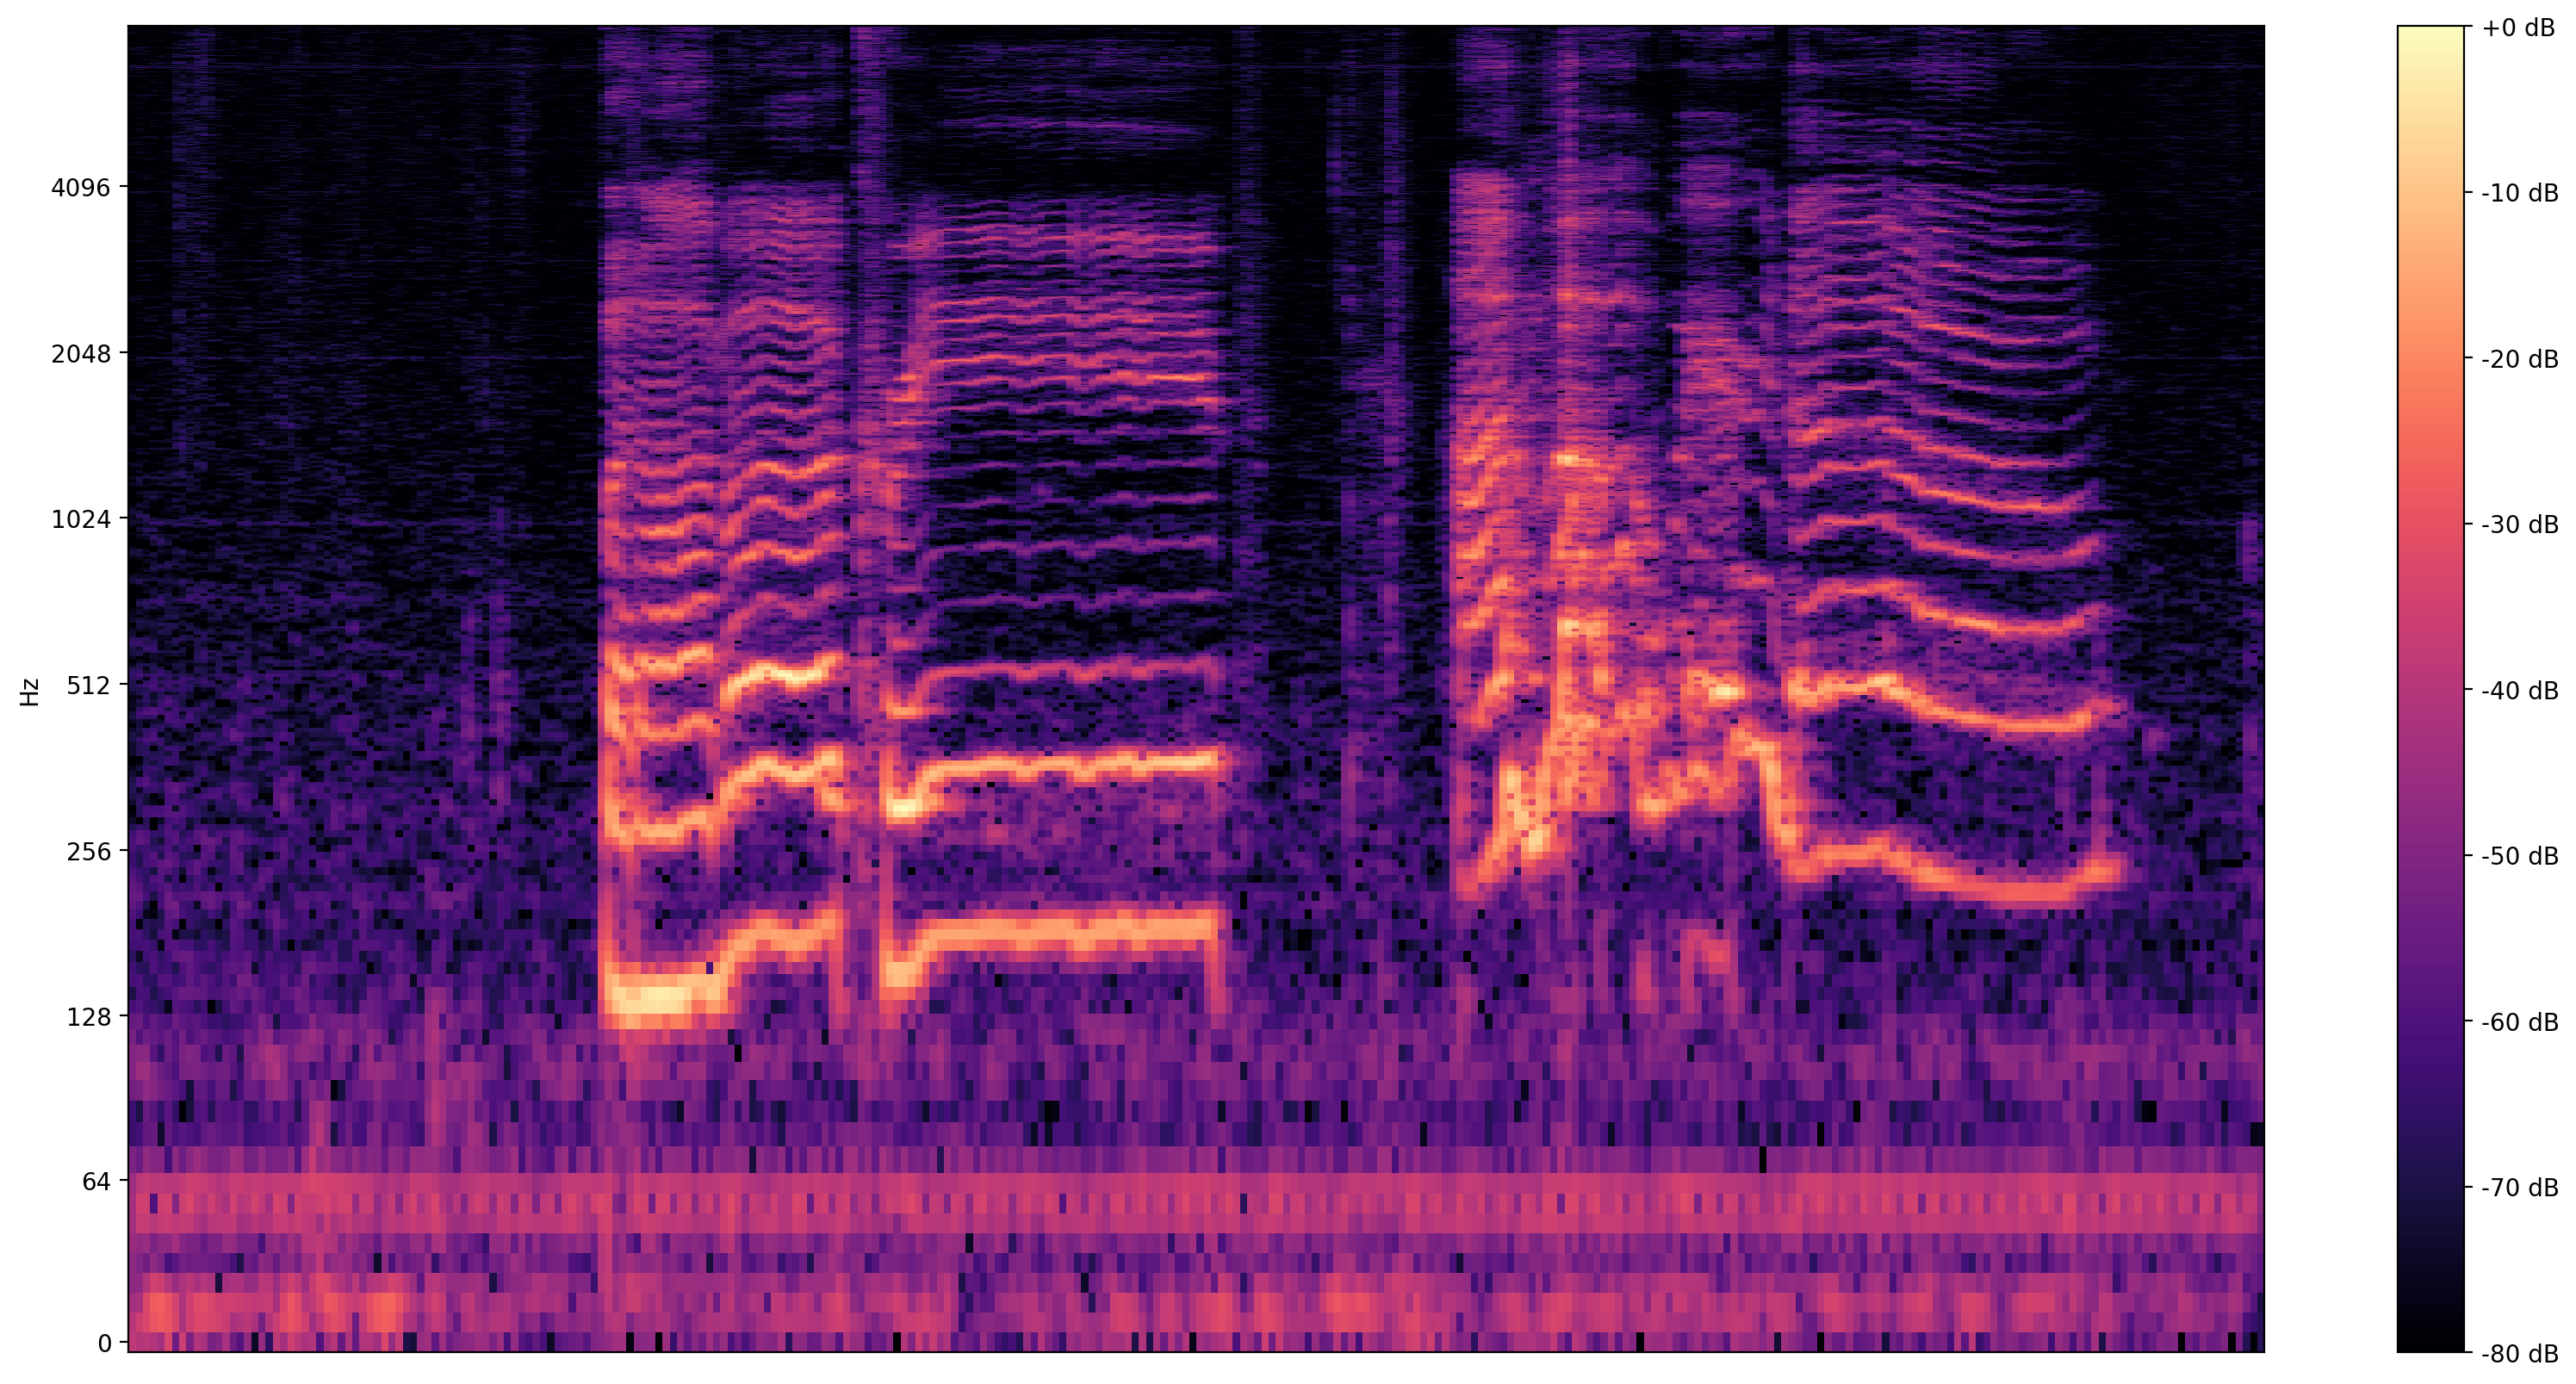

In [10]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log', 
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()


We need one last conversion here. The audio samples are in int16 format. They need to be normalized to floats between -1 and 1.

In [11]:
audio_samples = audio_samples / float(MAX_ABS_INT16)

# Executing the Model
Now is the easy part, let's load the model with **TensorFlow Hub**, and feed the audio to it.
SPICE will give us two outputs: pitch and uncertainty


**TensorFlow Hub** is a library for the publication, discovery, and consumption of reusable parts of machine learning models. It makes easy to use machine learning to solve your challenges.

To load the model you just need the Hub module and the URL pointing to the model:

In [12]:
# Loading the SPICE model is easy:
#model = hub.load("https://www.kaggle.com/models/google/spice/frameworks/TensorFlow1/variations/spice/versions/2")

import tensorflow as tf
model = tf.saved_model.load("/Users/hannahshader/Desktop/MLFeatures/src/pitch/")

**Note:** An interesting detail here is that all the model urls from Hub can be used for download and also to read the documentation, so if you point your browser to that link you can read documentation on how to use the model and learn more about how it was trained.

With the model loaded, data prepared, we need 3 lines to get the result: 

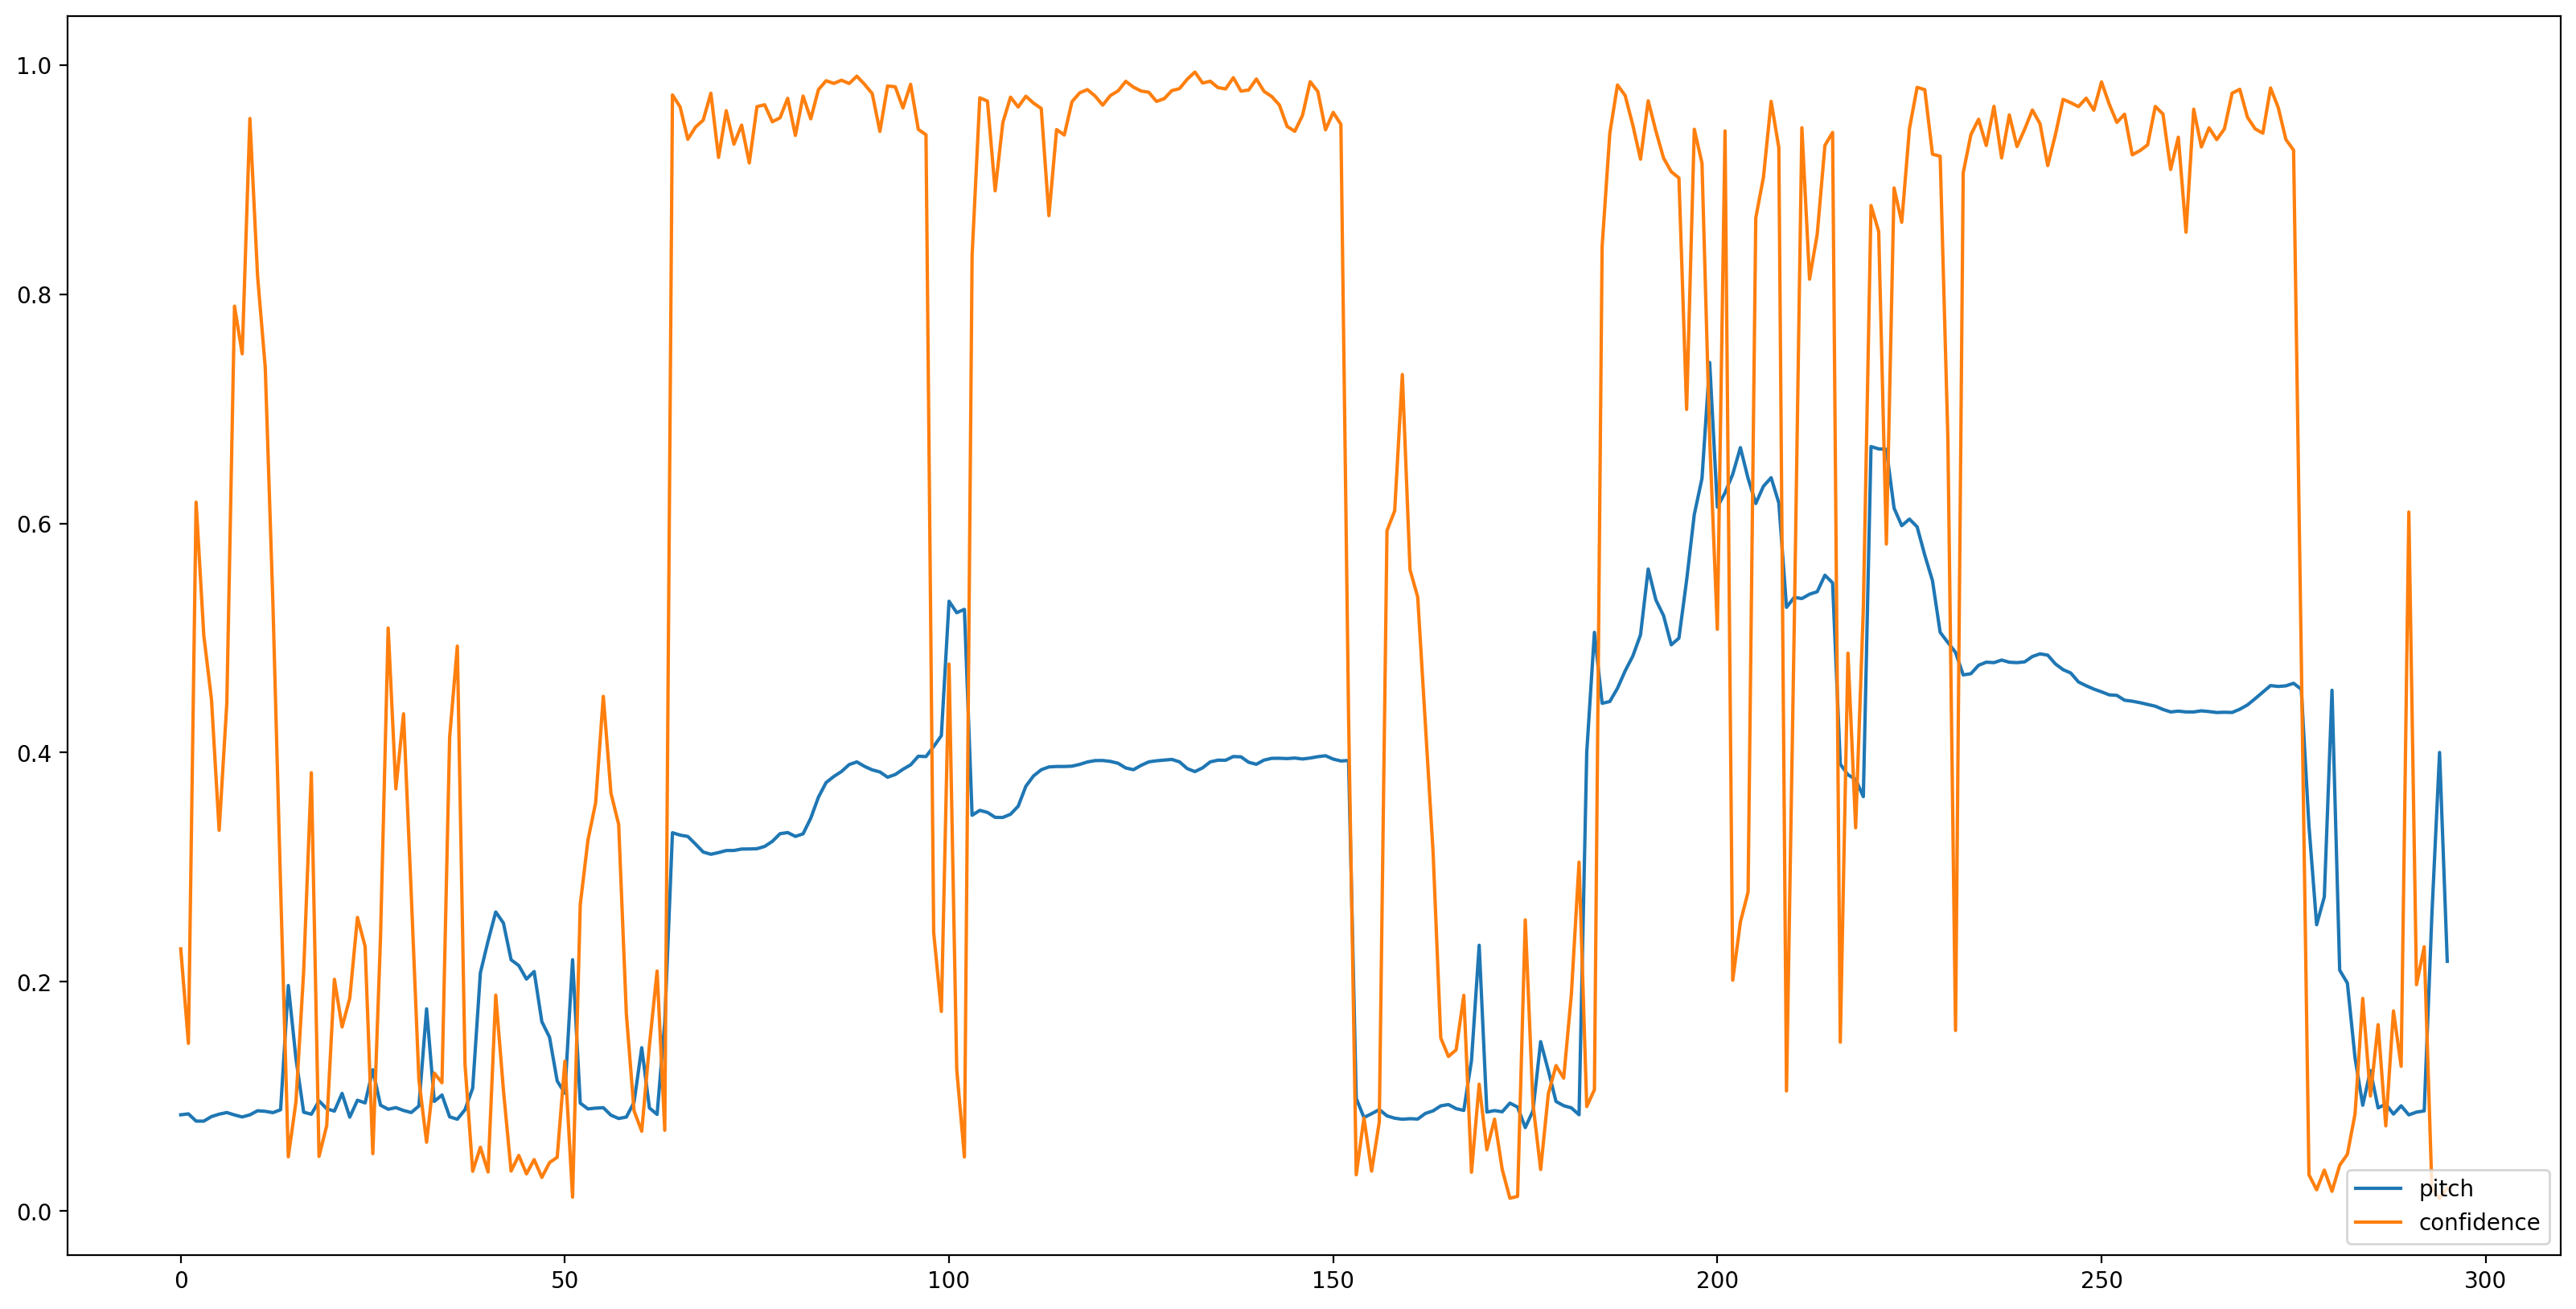

In [13]:
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

Let's make the results easier to understand by removing all pitch estimates with low confidence (confidence < 0.9) and plot the remaining ones.


Time: 0, Pitch: nan
Time: 1, Pitch: nan
Time: 2, Pitch: nan
Time: 3, Pitch: nan
Time: 4, Pitch: nan
Time: 5, Pitch: nan
Time: 6, Pitch: nan
Time: 7, Pitch: nan
Time: 8, Pitch: nan
Time: 9, Pitch: nan
Time: 10, Pitch: nan
Time: 11, Pitch: nan
Time: 12, Pitch: nan
Time: 13, Pitch: nan
Time: 14, Pitch: nan
Time: 15, Pitch: nan
Time: 16, Pitch: nan
Time: 17, Pitch: nan
Time: 18, Pitch: nan
Time: 19, Pitch: nan
Time: 20, Pitch: nan
Time: 21, Pitch: nan
Time: 22, Pitch: nan
Time: 23, Pitch: nan
Time: 24, Pitch: nan
Time: 25, Pitch: nan
Time: 26, Pitch: nan
Time: 27, Pitch: nan
Time: 28, Pitch: nan
Time: 29, Pitch: nan
Time: 30, Pitch: nan
Time: 31, Pitch: nan
Time: 32, Pitch: nan
Time: 33, Pitch: nan
Time: 34, Pitch: nan
Time: 35, Pitch: nan
Time: 36, Pitch: nan
Time: 37, Pitch: nan
Time: 38, Pitch: nan
Time: 39, Pitch: nan
Time: 40, Pitch: nan
Time: 41, Pitch: nan
Time: 42, Pitch: nan
Time: 43, Pitch: nan
Time: 44, Pitch: nan
Time: 45, Pitch: nan
Time: 46, Pitch: nan
Time: 47, Pitch: nan
Ti

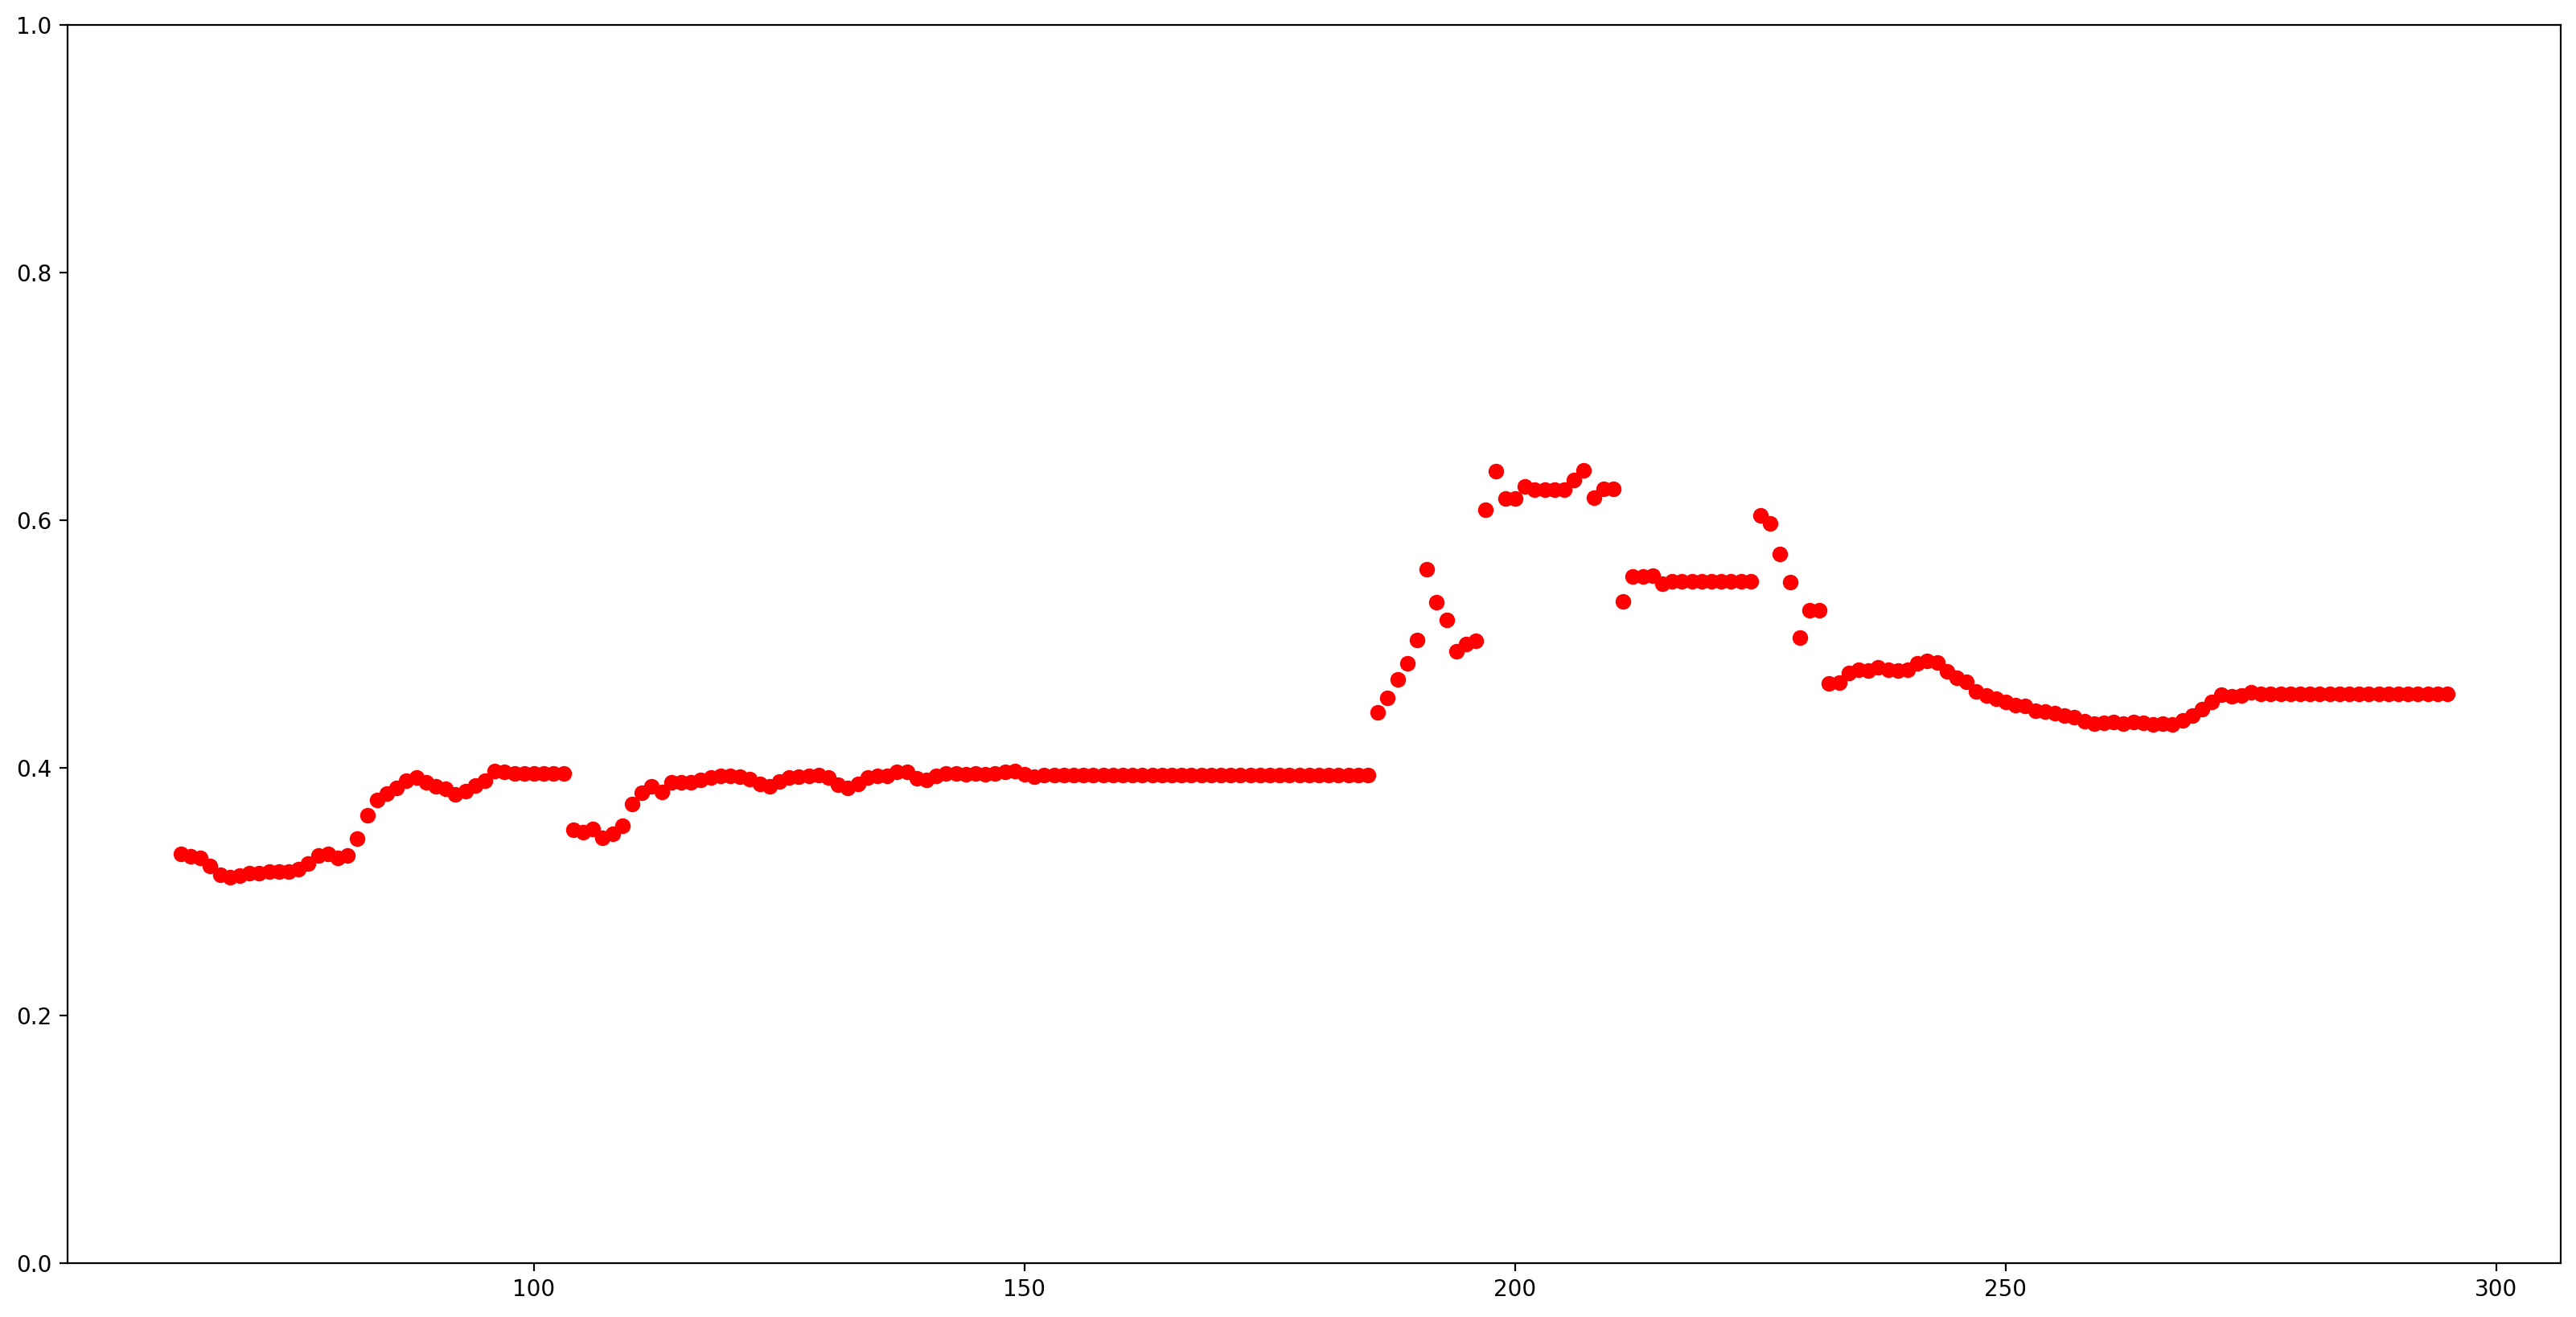

In [14]:
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt


# Get numpy arrays from the outputs of the model
pitch_outputs = np.array(pitch_outputs, dtype=float)
confidence_outputs = np.array(confidence_outputs)

# Calculate outlier points
def get_lower_and_upper_bounds(data):
    # Calculate Q1 and Q3
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Determine outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return lower_bound, upper_bound


# Create an array of pitches, setting to np.nan where confidence < 0.9
confident_pitch_outputs_y = np.where(confidence_outputs >= 0.9, pitch_outputs, np.nan)
pitch_outputs_x = np.arange(len(pitch_outputs))

# Initialize the Kalman filter with the mean of the window
initial_mean = np.nanmean(confident_pitch_outputs_y)
kf = KalmanFilter(initial_state_mean=pitch_outputs[0], n_dim_obs=1)


masked_pitch_outputs_y = np.ma.array(confident_pitch_outputs_y, mask=np.isnan(confident_pitch_outputs_y))
filtered_state_means, _ = kf.filter(masked_pitch_outputs_y)

# Fill missing pitches with filtered values
kalman_filled_pitch_outputs_y = np.where(np.isnan(confident_pitch_outputs_y), filtered_state_means[:, 0], confident_pitch_outputs_y)

# Get lower and upper bounds fo the dataset 
lower_bound, upper_bound = get_lower_and_upper_bounds(kalman_filled_pitch_outputs_y)

# Remove points that are outliers
kalman_filled_pitch_outputs_y[(kalman_filled_pitch_outputs_y < lower_bound) | (kalman_filled_pitch_outputs_y > upper_bound)] = np.nan


# Print results
for t, p in zip(pitch_outputs_x, kalman_filled_pitch_outputs_y):
    print(f"Time: {t}, Pitch: {p}")

# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(pitch_outputs_x, kalman_filled_pitch_outputs_y, c="r")
plt.show()


The pitch values returned by SPICE are in the range from 0 to 1. Let's convert them to absolute pitch values in Hz.

In [15]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)
    
confident_pitch_values_hz = [ output2hz(p) for p in kalman_filled_pitch_outputs_y ]

Now, let's see how good the prediction is: We will overlay the predicted pitches over the original spectrogram. To make the pitch predictions more visible, we changed the spectrogram to black and white.

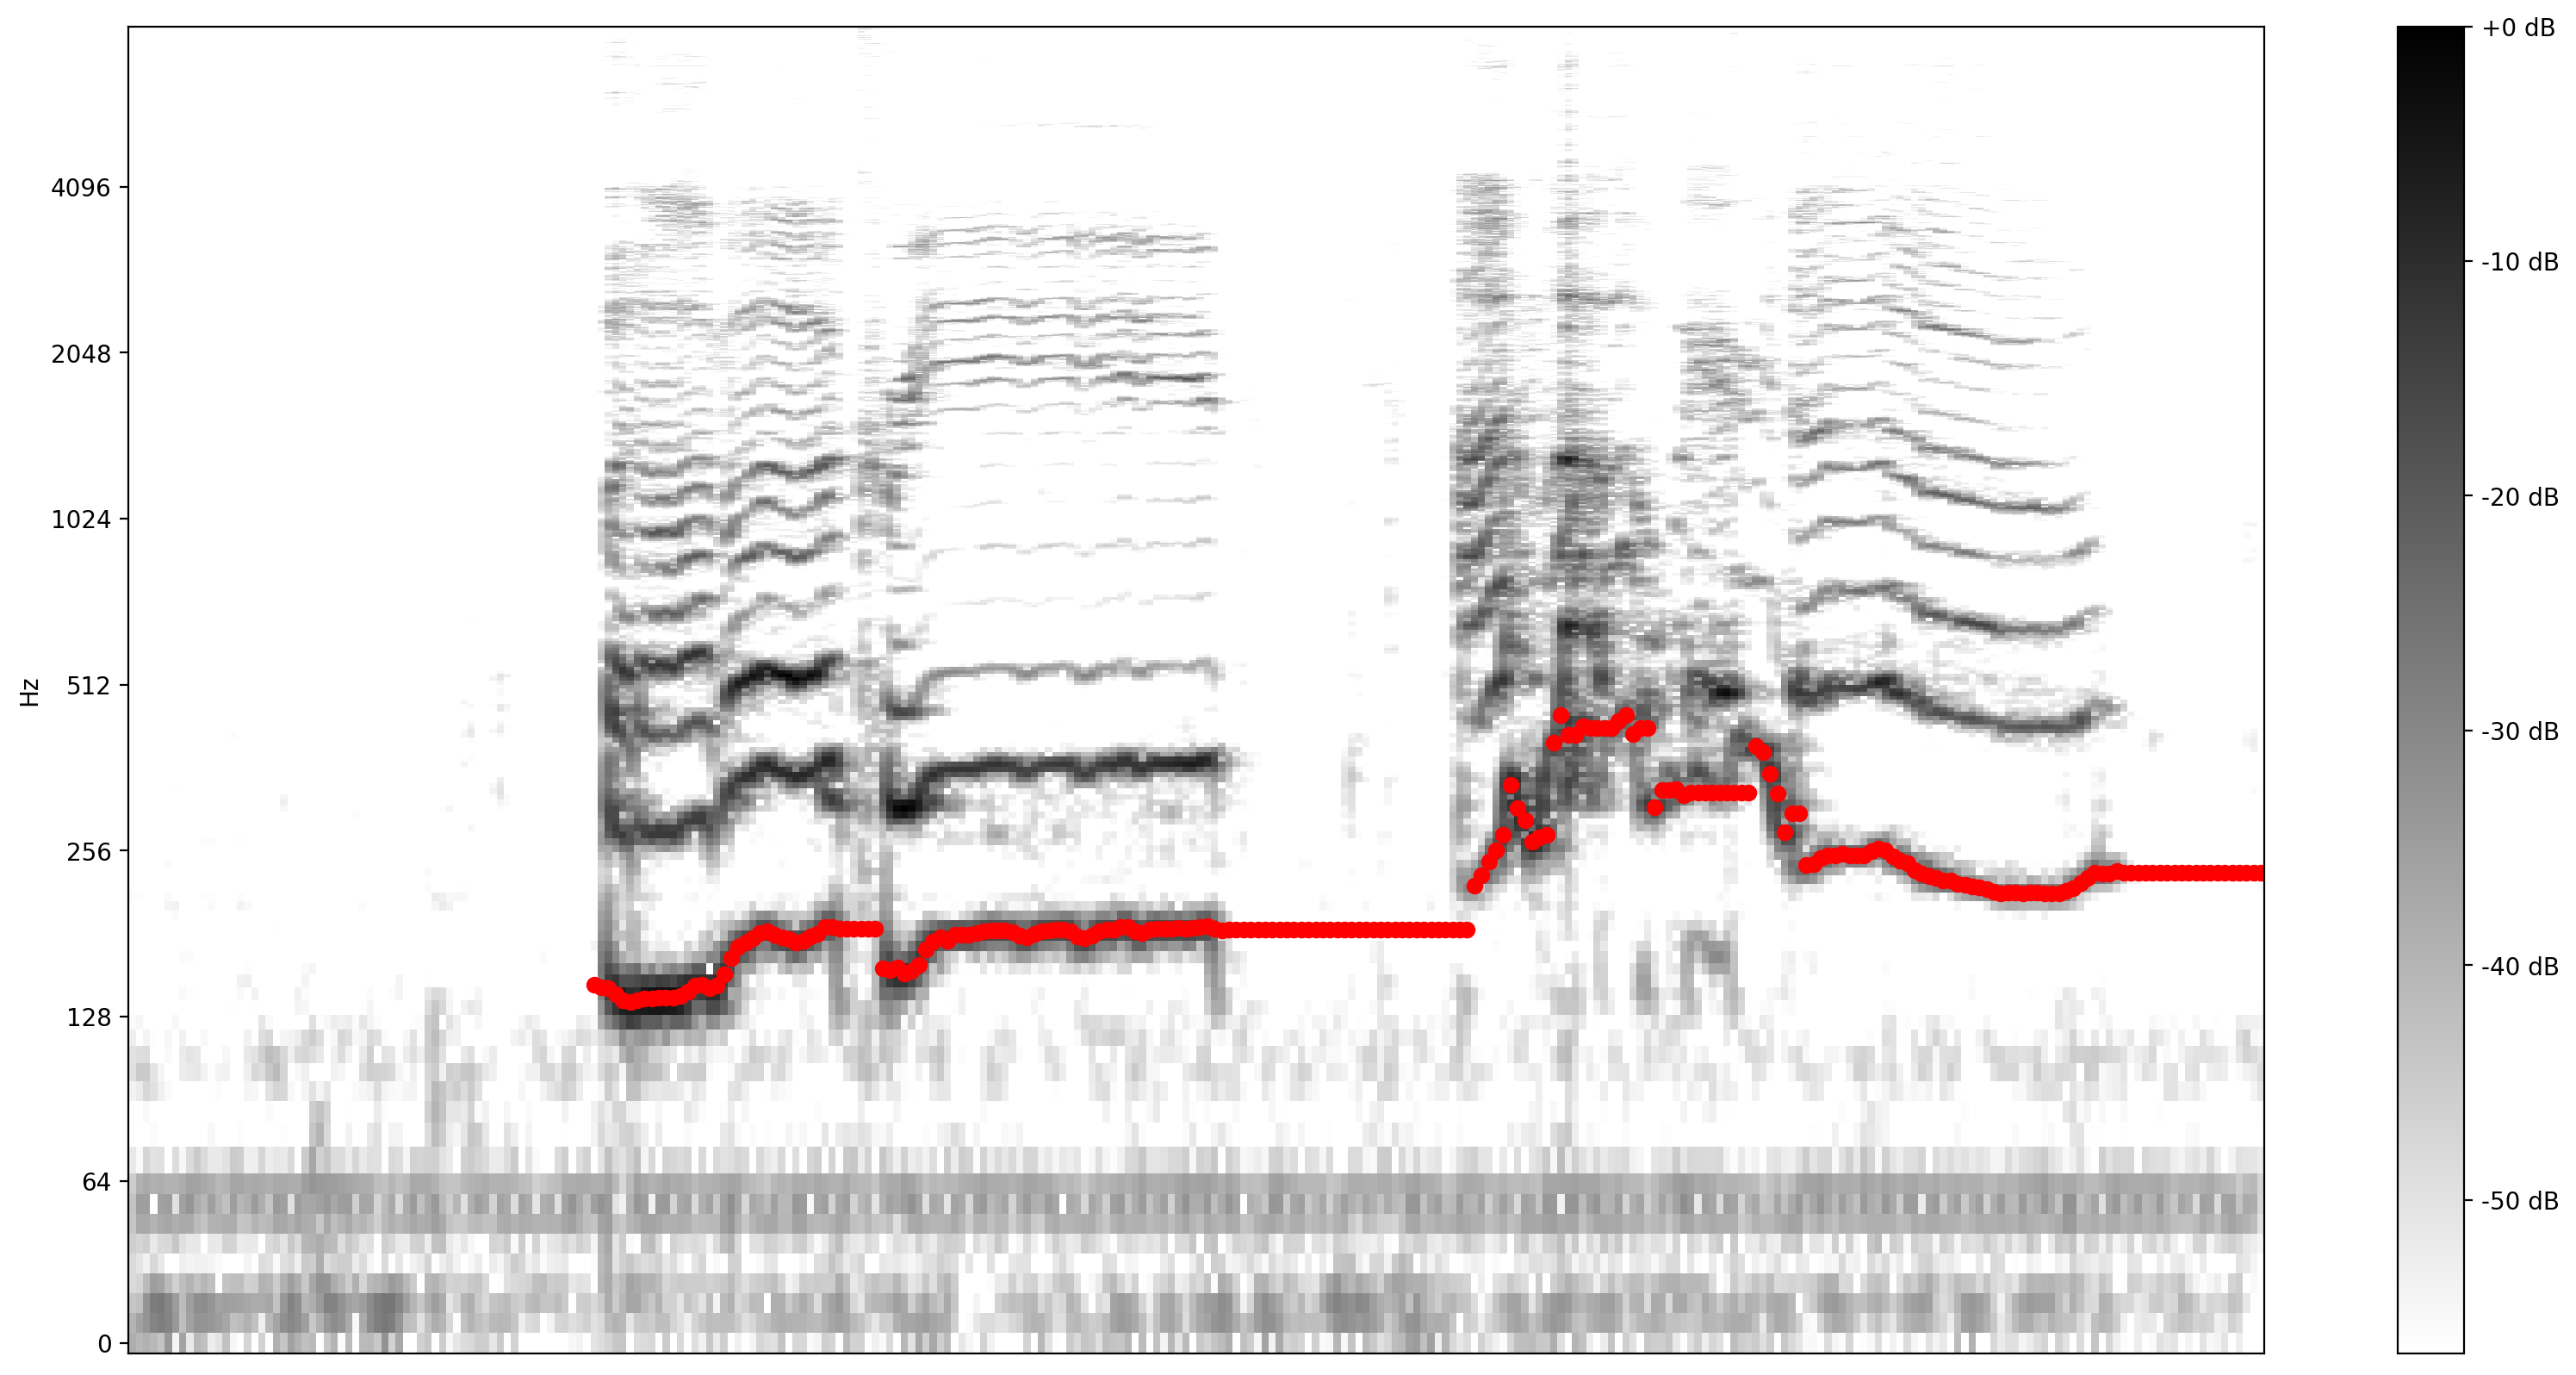

In [16]:
plot_stft(audio_samples / MAX_ABS_INT16 , 
          sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
# Note: conveniently, since the plot is in log scale, the pitch outputs 
# also get converted to the log scale automatically by matplotlib.
plt.scatter(pitch_outputs_x, confident_pitch_values_hz, c="r")

plt.show()

Hannah: Now to do the steps outlined in my algorithm. 

y values are:
[145.86827344 144.7670003  144.15297714 140.69953295 137.19626144
 136.21793445 136.94807146 137.84069623 137.86313151 138.49654834
 138.52904673 138.64555314 139.65214091 141.91314552 145.41328534
 145.94578537 144.16819067 145.35051087 152.76381556 163.32530887
 171.10567227 174.42020965 177.20449998 181.15111891 182.69331678
 180.11744289 178.13773252 176.9578301  174.0266108  175.52345746
 178.46202341 181.00455397 186.0109479  185.82972061 184.94840239
 184.94840239 184.94840239 184.94840239 184.94840239 184.94840239
 156.61109828 155.61403469 157.00613983 153.13296424 154.69584213
 158.70212272 169.11293691 174.75148792 178.19330713 175.30564815
 180.06435704 180.05509062 180.24268187 181.25590048 182.64661051
 183.45951212 183.52123012 182.99691072 181.91122169 179.21625205
 178.22786382 180.7117209  182.72759548 183.35602469 183.75135134
 184.14231218 182.71727945 178.85334219 177.1624476  179.28327737
 182.71545437 183.70106372 183.67503765 185.85290413 185.65507

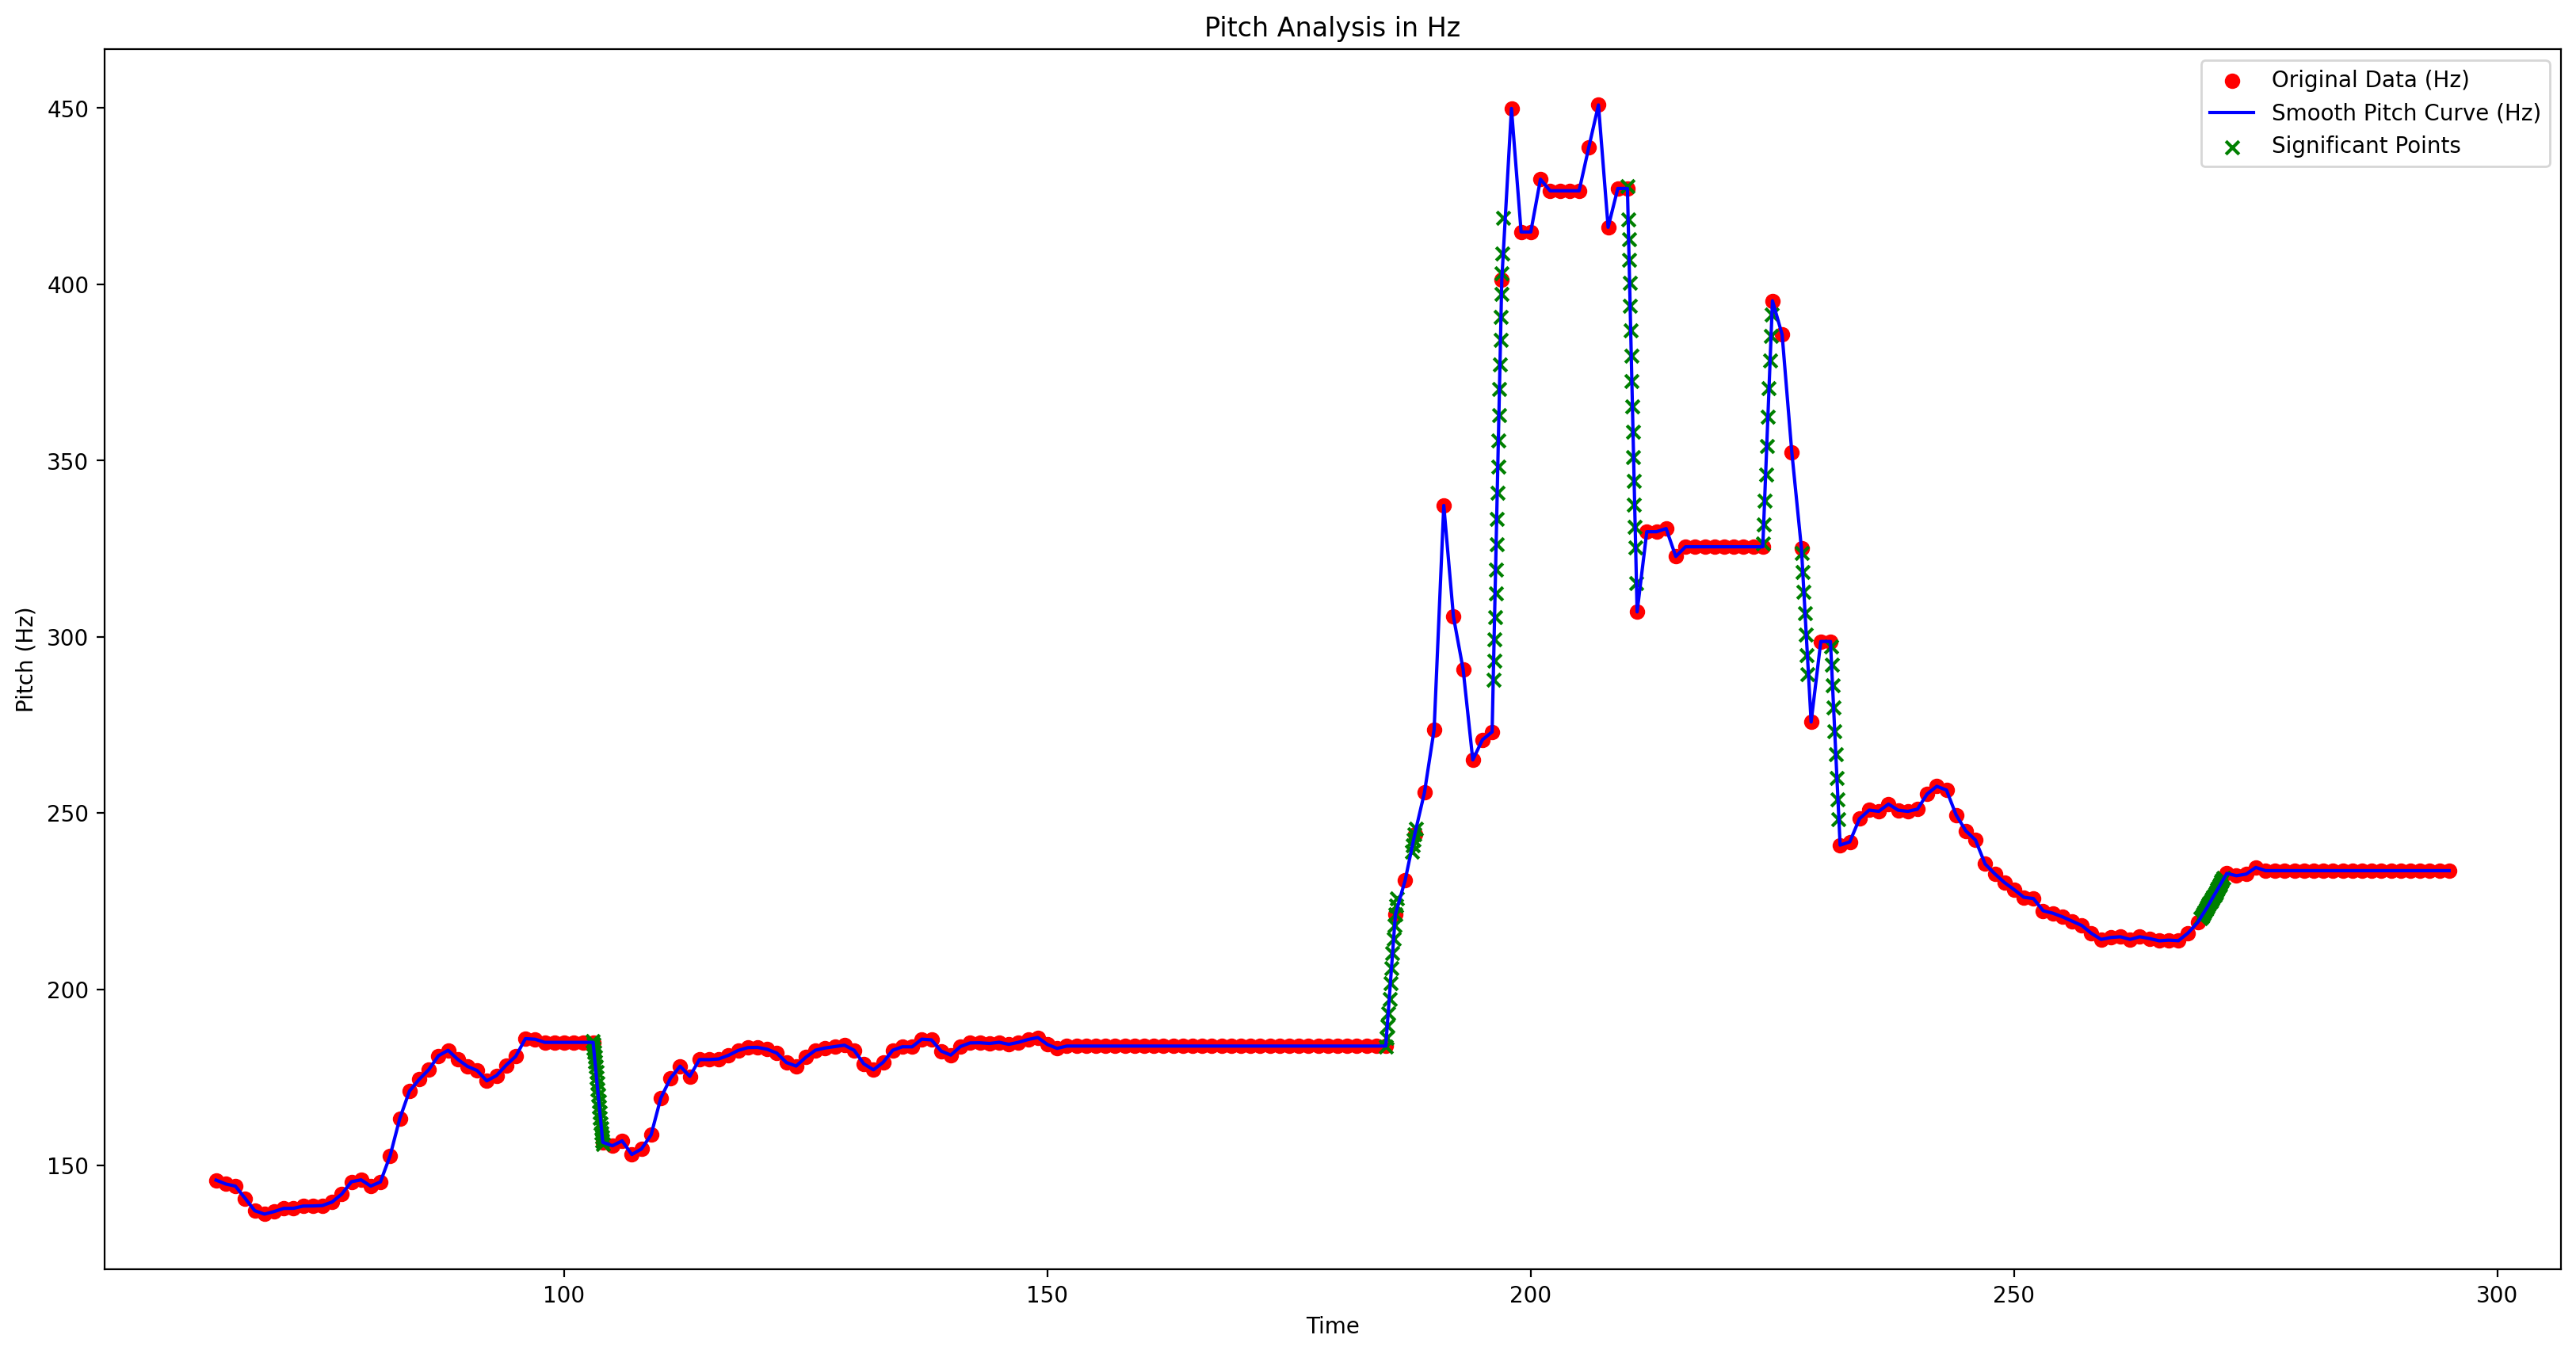

In [30]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy.interpolate import CubicSpline


# Convert arrays to Numpy arrays
pitch_outputs_x = np.array(pitch_outputs_x)
confident_pitch_values_hz = np.array(confident_pitch_values_hz)

# Filter out NaN values from confident_pitch_values_hz and corresponding values in pitch_outputs_x
valid_indices = ~np.isnan(confident_pitch_values_hz) 
filtered_pitch_outputs_x = pitch_outputs_x[valid_indices]
filtered_confident_pitch_values_hz = confident_pitch_values_hz[valid_indices]

print("y values are:")
print(filtered_confident_pitch_values_hz)
print("x values are:")
print(filtered_pitch_outputs_x)




# Create function and derivative of the cubic supline function
cs = CubicSpline(filtered_pitch_outputs_x, filtered_confident_pitch_values_hz)
cs_prime = cs.derivative()

all_audio_start_time = min(filtered_pitch_outputs_x)
all_audio_end_time = max(filtered_pitch_outputs_x)
print("all_audio_start_time is: ", all_audio_start_time)


# Select arbirary value for constant for inner window analysis
# Select aribrary value for constant for cross window analysis
k = 5
K = 1

# Later change to set?
significant_points = []

# Gets the mean value fo the cubic supline function in a range
def mean_value_of_spline(cs, start, end):
    integral = cs.integrate(start, end)
    mean_value = integral / (end - start)
    return mean_value

# Gets the MAD value fo the cubic supline function in a range
def calculate_madiw(cs, start, end, MIW):
    def adiw(t):
        return np.abs(cs(t) - MIW)

    vectorized_adiw = np.vectorize(adiw)

    t = np.linspace(start, end, 1000) 
    integral_adiw = np.trapz(vectorized_adiw(t), t)
    MADIW = integral_adiw / (end - start)
    return MADIW

# For a given window, adds points outside of MAD threshold to the significant points list
def inner_window_analysis(cs, cs_prime, start_time, end_time, k):
    mean_pitch_of_window = mean_value_of_spline(cs, start_time, end_time)
    mean_pitch_change_of_window = mean_value_of_spline(cs_prime, start_time, end_time)
    mad_of_window = calculate_madiw(cs_prime, start_time, end_time, mean_pitch_change_of_window)


    for t in np.linspace(start_time, end_time, 500):
        curr_pitch_rate_of_change = cs_prime(t)
        curr_pitch = cs(t)
        #print(curr_pitch)
        if abs(curr_pitch_rate_of_change - mean_pitch_change_of_window) > k * mad_of_window:
            significant_tuple = (t, curr_pitch)
            significant_points.append(significant_tuple)

    return [mean_pitch_of_window, start_time, end_time]


def cross_window_analysis(cross_window_data, scope_hyperparam, K):
    timestamps = []
    for i in range(scope_hyperparam, len(cross_window_data) - scope_hyperparam):
        means = [cross_window_data[i][0]]  
        for j in range(1, scope_hyperparam + 1):
            means.append(cross_window_data[i-j][0]) 
            if i + j < len(cross_window_data): 
                means.append(cross_window_data[i+j][0])

        mean = statistics.mean(means)
        mad = statistics.mean([abs(item - mean) for item in means])

        if abs(cross_window_data[i][0] - mean) > (K * mad):
            timestamps.append([cross_window_data[i][1], cross_window_data[i][2]])

    return timestamps

# Iterate through windows
window_size = 50
shift_size = 25
assert(window_size > shift_size)

# For each window, use inner_window_analysis function to get significant points
# For each window, store a list where each element is: [mean, start time, end time]
cross_window_data = []
curr = all_audio_start_time
while curr < all_audio_end_time:
    curr_window_data = inner_window_analysis(cs, cs_prime, curr, curr + window_size, k)
    curr = curr + shift_size
    cross_window_data.append(curr_window_data)


#Set an arbitrary hypermarater for how many windows around the target we want to inspect
local_window_hyperparameter = 2

# Store of list where is element is: [start time, end time]
# These start and end times indicate windows with usual pitch changes
cross_window_analysis_timestamps = cross_window_analysis(cross_window_data, local_window_hyperparameter, K)


# Plot the cubic supline pitch function
plt.figure(figsize=(20, 10))
plt.scatter(filtered_pitch_outputs_x, filtered_confident_pitch_values_hz, color="r", label="Original Data (Hz)")
plt.plot(filtered_pitch_outputs_x, cs(filtered_pitch_outputs_x), label="Smooth Pitch Curve (Hz)", color="blue")

plt.title("Pitch Analysis in Hz")
plt.xlabel("Time")
plt.ylabel("Pitch (Hz)")
plt.legend()

# Plot the significant values 
t_values, pitch_values = zip(*significant_points)
plt.scatter(t_values, pitch_values, color="green", label="Significant Points", marker='x')

# Output the data to a file
with open('data_output.txt', 'w') as file:
    file.write("Inner window analysis\n")
    file.write("(All points with usual pitch change in a window as timestamp and pitch)\n")
    for item in significant_points:
        file.write(f"Time stamp: {item[0]}, Pitch value: {item[1]}\n")
    file.write("Corss window analysis\n")
    file.write("(All start and end timestamps of windows with unusual pitch changes)\n")
    for item in cross_window_analysis_timestamps:
        file.write(f"Window start time: {item[0]}, Window end time: {item[1]}\n")

plt.legend()
plt.show()


# Converting to musical notes

Now that we have the pitch values, let's convert them to notes!
This is part is challenging by itself. We have to take into account two things:
1. the rests (when there's no singing) 
2. the size of each note (offsets) 

### 1: Adding zeros to the output to indicate when there's no singing

In [18]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

NameError: name 'indices' is not defined

### 2: Adding note offsets

When a person sings freely, the melody may have an offset to the absolute pitch values that notes can represent.
Hence, to convert predictions to notes, one needs to correct for this possible offset.
This is what the following code computes.

In [ ]:
A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def hz2offset(freq):
  # This measures the quantization error for a single note.
  if freq == 0:  # Rests always have zero error.
    return None
  # Quantized note.
  h = round(12 * math.log2(freq / C0))
  return 12 * math.log2(freq / C0) - h


# The ideal offset is the mean quantization error for all the notes
# (excluding rests):
offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)


offsets:  [0.2851075707500712, 0.3700368844097355, 0.2861658038323682, 0.19609005646164235, 0.17851737247163868, 0.2733467103665532, -0.4475297470266071, -0.24651621146742997, -0.1796576844031108, -0.23059760405365637, -0.37826153113190486, -0.4725100625926686, -0.345721333759478, -0.2436685682708486, -0.1818925674134988, -0.1348077739650435, -0.24551624699179797, -0.4454903457934165, -0.31267739488426827, -0.12241723670307181, -0.06614479972665066, -0.06702634735648871, -0.1744116301709866, -0.29365739389006507, -0.32520890458170726, -0.056438377636119696, 0.1470487542575114, 0.17167006002122775, 0.16529246704037348, 0.09569531546290477, -0.006323616641203955, -0.11800010039155495, -0.18835286422317665, -0.17934754504506145, -0.17215419157092526, -0.23695828034226452, -0.34594313039129077, -0.39380233241860907, -0.2528674895936689, -0.11009436621014146, -0.07118785365169344, -0.08042248799149121, -0.12799786551538972, -0.16227484329287023, -0.059321733849699854, 0.10667988763506742, 0

We can now use some heuristics to try and estimate the most likely sequence of notes that were sung.
The ideal offset computed above is one ingredient - but we also need to know the speed (how many predictions make, say, an eighth?), and the time offset to start quantizing.  To keep it simple, we'll just try different speeds and time offsets and measure the quantization error, using in the end the values that minimize this error.

In [ ]:
def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  # Create a rest if 80% is silent, otherwise create a note.
  if zero_values_count > 0.8 * len(group):
    # Interpret as a rest. Count each dropped note as an error, weighted a bit
    # worse than a badly sung note (which would 'cost' 0.5).
    return 0.51 * len(non_zero_values), "Rest"
  else:
    # Interpret as note, estimating as mean of non-rest predictions.
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    # Quantization error is the total difference from the quantized note.
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])
    return error, note


def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  # Apply the start offset - we can just add the offset as rests.
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  # Collect the predictions for each note (or rest).
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests


best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
  for prediction_start_offset in range(predictions_per_note):

    error, notes_and_rests = get_quantization_and_error(
        pitch_outputs_and_rests, predictions_per_note,
        prediction_start_offset, ideal_offset)

    if error < best_error:      
      best_error = error
      best_notes_and_rests = notes_and_rests
      best_predictions_per_note = predictions_per_note

# At this point, best_notes_and_rests contains the best quantization.
# Since we don't need to have rests at the beginning, let's remove these:
while best_notes_and_rests[0] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[1:]
# Also remove silence at the end.
while best_notes_and_rests[-1] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[:-1]

Now let's write the quantized notes as sheet music score!

To do it we will use two libraries: [music21](http://web.mit.edu/music21/) and [Open Sheet Music Display](https://github.com/opensheetmusicdisplay/opensheetmusicdisplay)

**Note:** for simplicity, we assume here that all notes have the same duration (a half note).

In [ ]:
# Creating the sheet music score.
sc = music21.stream.Score()
# Adjust the speed to match the actual singing.
bpm = 60 * 60 / best_predictions_per_note
print ('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0,a)

for snote in best_notes_and_rests:   
    d = 'half'
    if snote == 'Rest':      
      sc.append(music21.note.Rest(type=d))
    else:
      sc.append(music21.note.Note(snote, type=d))

bpm:  78.26086956521739


In [ ]:
#@title [Run this] Helper function to use Open Sheet Music Display (JS code) to show a music score

from IPython.core.display import display, HTML, Javascript
import json, random

def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)
    
def showMusicXML(xml):
    DIV_ID = "OSMD_div"
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    script = """
    var div_id = %%DIV_ID%%;
    function loadOSMD() { 
        return new Promise(function(resolve, reject){
            if (window.opensheetmusicdisplay) {
                return resolve(window.opensheetmusicdisplay)
            }
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
          drawingParameters: "compacttight"
        });
        openSheetMusicDisplay
            .load(%%data%%)
            .then(
              function() {
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('%%DIV_ID%%',DIV_ID).replace('%%data%%',json.dumps(xml))
    display(Javascript(script))
    return

/var/folders/7f/_pntb8wx2mjdt4029s7llmxc0000gn/T/ipykernel_9842/2305315633.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [ ]:
# rendering the music score
showScore(sc)
print(best_notes_and_rests)

/Users/hannahshader/anaconda3/envs/poc_pitch/lib/python3.10/site-packages/music21/musicxml/m21ToXml.py:531: MusicXMLWarning: <music21.stream.Score 0x28ba45b70> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{sc} is not well-formed; see isWellFormedNotation()',


<IPython.core.display.Javascript object>

['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4']


Let's convert the music notes to a MIDI file and listen to it.

To create this file, we can use the stream we created before.

In [ ]:
# Saving the recognized musical notes as a MIDI file
converted_audio_file_as_midi = converted_audio_file[:-4] + '.mid'
fp = sc.write('midi', fp=converted_audio_file_as_midi)

In [ ]:
wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
print(wav_from_created_midi)

converted_audio_file.mid_midioutput.wav


To listen to it on colab, we need to convert it back to wav. An easy way of doing that is using Timidity.

In [ ]:
!timidity $converted_audio_file_as_midi -Ow -o $wav_from_created_midi

Playing converted_audio_file.mid
MIDI file: converted_audio_file.mid
Format: 1  Tracks: 2  Divisions: 10080
Track name: 
Playing time: ~16 seconds
Notes cut: 0
Notes lost totally: 0


And finally, listen the audio, created from notes, created via MIDI from the predicted pitches, inferred by the model!


In [ ]:
Audio(wav_from_created_midi)